In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.display import display
import glob
import pandas as pd

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

## 加载数据

In [2]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...
Load datasets/CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_18_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_24_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_28_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_4_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_18_10.xlsx .

Load datasets/CALCE/CS2_38\CS2_38_10_14_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_21_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_28_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_01_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_08_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_15_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_22_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_24_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_06_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_13_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_20_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_23_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_10_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_18_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_24_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_28_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_2_10_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_2_4_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_8_17_10.xlsx ...
Load datasets/CALCE/

In [3]:
len(list(Battery['CS2_35']['capacity']))

882

## 画出数据

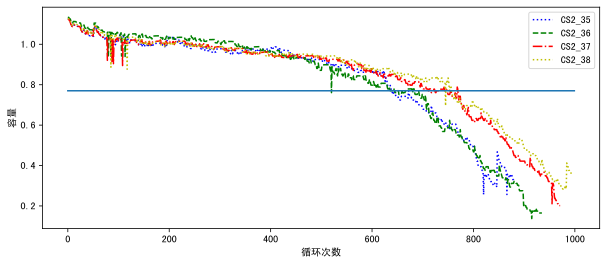

In [4]:
%matplotlib inline

def matplot_battery_list(battery_data_list):
    color_list = ['b:', 'g--', 'r-.', 'y:']
    # 1.创建画布
    plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')

    # 2.绘制折线图
    for index, data in enumerate(battery_data_list):
        plt.plot([i for i in range(len(battery_data_list[index]))], battery_data_list[index], color_list[index])

    plt.plot([i for i in range(1000)], [1.1 * 0.7 ] * 1000)

    # 图例
    plt.legend([name for name in Battery_list])

Battery_data_list = [list(Battery[i]['capacity']) for i in Battery_list]
matplot_battery_list(Battery_data_list)

## 创建评估指标函数

In [5]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 卡尔曼滤波

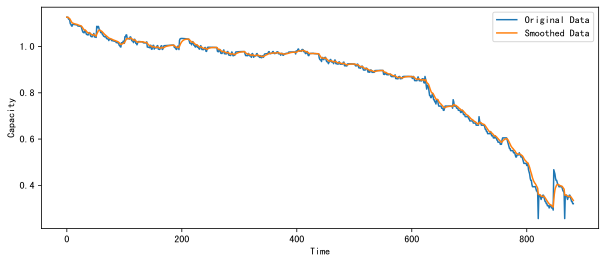

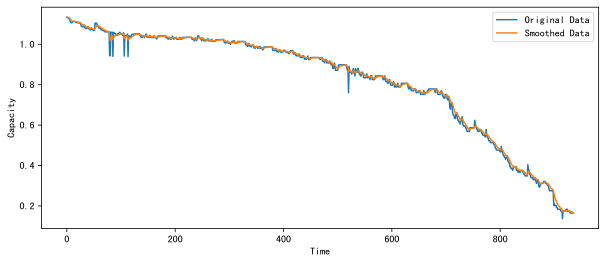

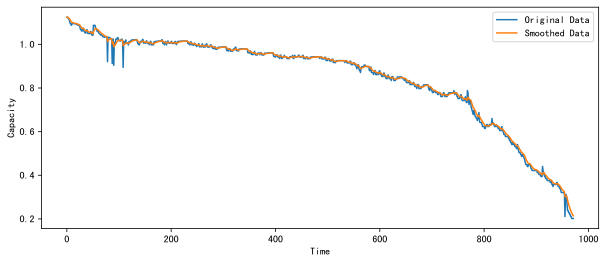

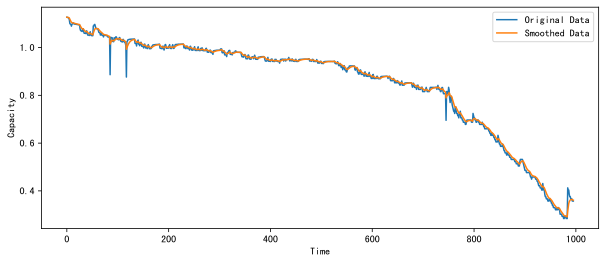

battery_index:0    , MAE:0.0071 , RMSE:0.0119 , RE:0.0000
battery_index:1    , MAE:0.0076 , RMSE:0.0121 , RE:0.0000
battery_index:2    , MAE:0.0069 , RMSE:0.0109 , RE:0.0000
battery_index:3    , MAE:0.0069 , RMSE:0.0112 , RE:0.0000


In [6]:
# Kalman滤波函数
def kalman_filter(data, process_variance, measurement_variance):
    # 初始化滤波器参数
    state = data[0]  # 初始状态
    state_estimate = state
    estimate_error = 1.0
    
    # 存储平滑后的数据
    smoothed_data = [state]
    
    for measurement in data[1:]:
        # 预测步骤
        prediction = state_estimate
        prediction_error = estimate_error + process_variance
        
        # 更新步骤
        kalman_gain = prediction_error / (prediction_error + measurement_variance)
        state_estimate = prediction + kalman_gain * (measurement - prediction)
        estimate_error = (1 - kalman_gain) * prediction_error
        
        # 存储平滑后的数据
        smoothed_data.append(state_estimate)
        state = state_estimate
    
    return np.array(smoothed_data)

Kalman_battery_data_list = []
for b_data in Battery_data_list:
    # 原始的时间序列数据
    original_data = b_data
    # 使用Kalman滤波
    process_variance = 0.05  # 系统噪音方差
    measurement_variance = 1  # 观测噪音方差
    smoothed_data = kalman_filter(original_data, process_variance, measurement_variance)
    Kalman_battery_data_list.append(smoothed_data)

    # 可视化原始数据和平滑后的数据
    fig = plt.figure(figsize=(10, 4), dpi=80)
    plt.plot(original_data, label='Original Data')
    plt.plot(smoothed_data, label='Smoothed Data')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Capacity')
    display(fig)
    plt.close()

# 检查下 卡尔曼滤波后的数据的指标评分
rate_i = 0
for o_data, k_data in zip(Battery_data_list, Kalman_battery_data_list):
    mae, rmse, r2 = evaluation(o_data, k_data)
    re = relative_error(o_data, k_data, threshold=2 * 0.7)
    battery_index = rate_i
    rate_i+=1
    print('battery_index:{:<4d} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(battery_index, mae, rmse, re))

## 构建训练序列数据

In [7]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_list, battery_i, window_size=16):
    data_sequence = Battery[Battery_list[battery_i]]['capacity']
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for i, v in enumerate(data_list):
        if i != battery_i:
            data_x, data_y = build_seq(text=v, window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [8]:
train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, 0, window_size=64)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 2, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y.shape)
        
        print(x)
        print(y)
        break



validate_train_iter(train_iter)

torch.Size([2, 64])
torch.Size([2, 64])
tensor([[1.1338, 1.1336, 1.1333, 1.1315, 1.1303, 1.1289, 1.1258, 1.1222, 1.1192,
         1.1164, 1.1148, 1.1144, 1.1141, 1.1138, 1.1136, 1.1133, 1.1130, 1.1120,
         1.1111, 1.1103, 1.1096, 1.1090, 1.1085, 1.1079, 1.1074, 1.1070, 1.1047,
         1.1016, 1.0989, 1.0965, 1.0944, 1.0943, 1.0945, 1.0927, 1.0901, 1.0879,
         1.0860, 1.0845, 1.0850, 1.0854, 1.0839, 1.0824, 1.0813, 1.0794, 1.0777,
         1.0781, 1.0785, 1.0771, 1.0759, 1.0747, 1.0737, 1.0727, 1.0792, 1.0831,
         1.0875, 1.0910, 1.0920, 1.0916, 1.0910, 1.0890, 1.0884, 1.0869, 1.0851,
         1.0826],
        [1.1336, 1.1333, 1.1315, 1.1303, 1.1289, 1.1258, 1.1222, 1.1192, 1.1164,
         1.1148, 1.1144, 1.1141, 1.1138, 1.1136, 1.1133, 1.1130, 1.1120, 1.1111,
         1.1103, 1.1096, 1.1090, 1.1085, 1.1079, 1.1074, 1.1070, 1.1047, 1.1016,
         1.0989, 1.0965, 1.0944, 1.0943, 1.0945, 1.0927, 1.0901, 1.0879, 1.0860,
         1.0845, 1.0850, 1.0854, 1.0839, 1.0824, 1.

## 绘制 out 和  tgt_y的对比图

In [9]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(7, 2), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 2维数据的残差1D卷积网络

In [10]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        X = torch.cat([X, X], dim=1)
        
        Y = X + Y
        return F.relu(Y)


    
blk = Residual1D(32, 64, 3)
X = torch.rand(50, 32, 16)
Y = blk(X)
Y.shape

torch.Size([50, 64, 16])

## 随机种子

In [11]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 搭建模型

In [12]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=128, nhead=16, num_encoder_layers=2, dim_feedforward=512, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        self.rcnn = Residual1D(d_model, d_model * 2, kernel_size=kernel_size)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        

        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
    
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)

        out = self.predictor(out)
    
        return out

## 测试模型的输出形状

In [13]:
# 测试模型的输出形状
net = Net(d_model=32).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((50, 64), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([50, 64, 1])


## 一个批次的训练函数

In [14]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
        #print(src.device)
        #print(tgt.device)
        
        out = net(x)
        
    
        #print('111out', out.shape) # (50, 153, 1)
        # print('111tgt_y', tgt_y.shape) # (50, 153)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        #print('222out', out[-1, :, :].cpu().data.numpy().shape) # (50, 153, 1)
        #print('222tgt_y', tgt_y.shape) # (50, 153)
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [15]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)

        if (len(re_epoch_list) == 0 or (r2_epoch_list[-1] < r2)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)


        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

        
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [16]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        
        
        pred_next_point = pred.cpu().data.numpy()[-1]
        
        
        pre_list.append(pred_next_point)
        
        
    return pre_list
        
    
# x = train_data.copy()
# pred_list = predict(net, train_data, test_data, 2)
# print((pred_list))
# print((test_data))

# print(len(pred_list))
# print(len(test_data))
# matlab_make(pred_list, test_data)

## 开始训练 num_epochs = 500

In [20]:
# 电池额定容量
Rated_Capacity = 1.1

# 超参数
d_model = 64
nhead = 8
num_encoder_layers = 2
dim_feedforward = 128

batch_size = 100
lr = 0.0001
weight_decay = 0.00001
num_epochs = 500
window_size = 64

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 CS2_35 为测试数据的 数据集 开始训练
seed: 0, 测试集: CS2_35, epoch:1    , loss:0.0339620113 , MAE:0.3276 , RMSE:0.3873 , RE:0.4177 , R2:-2.5234
seed: 0, 测试集: CS2_35, epoch:2    , loss:0.0189907365 , MAE:0.1499 , RMSE:0.2443 , RE:0.4177 , R2:-0.4017
seed: 0, 测试集: CS2_35, epoch:85   , loss:0.0006454922 , MAE:0.1398 , RMSE:0.2307 , RE:0.4177 , R2:-0.2501
seed: 0, 测试集: CS2_35, epoch:88   , loss:0.0007124752 , MAE:0.1300 , RMSE:0.2156 , RE:0.4177 , R2:-0.0920
seed: 0, 测试集: CS2_35, epoch:89   , loss:0.0004918620 , MAE:0.1274 , RMSE:0.2130 , RE:0.4177 , R2:-0.0661
seed: 0, 测试集: CS2_35, epoch:90   , loss:0.0008833826 , MAE:0.1534 , RMSE:0.2069 , RE:0.1785 , R2:-0.0053
seed: 0, 测试集: CS2_35, epoch:115  , loss:0.0005358282 , MAE:0.0593 , RMSE:0.0937 , RE:0.1854 , R2:0.7939
seed: 0, 测试集: CS2_35, epoch:116  , loss:0.0003874557 , MAE:0.0295 , RMSE:0.0442 , RE:0.0971 , R2:0.9541
seed: 

seed: 1, 测试集: CS2_38, epoch:202  , loss:0.0001790185 , MAE:0.0610 , RMSE:0.1027 , RE:0.1455 , R2:0.7407
seed: 1, 测试集: CS2_38, epoch:228  , loss:0.0001380456 , MAE:0.0232 , RMSE:0.0427 , RE:0.0058 , R2:0.9551
seed: 1, 测试集: CS2_38, epoch:348  , loss:0.0000500531 , MAE:0.0238 , RMSE:0.0351 , RE:0.0648 , R2:0.9696
---------------------------------
re_s [0.053726169844020795, 0.05670103092783505, 0.03828483920367534, 0.06484149855907781]
---------------------------------
re mean: 0.053388384633652246
mae mean: 0.021457564137882953
rmse mean: 0.03017289890876028
r2 mean: 0.9801773979801692
---------------------------------
*******************************************************************************************************************
当前的 seed 为 2
以电池 CS2_35 为测试数据的 数据集 开始训练
seed: 2, 测试集: CS2_35, epoch:1    , loss:0.0375195593 , MAE:0.3787 , RMSE:0.4113 , RE:0.9983 , R2:-2.9743
seed: 2, 测试集: CS2_35, epoch:2    , loss:0.0214251392 , MAE:0.2521 , RMSE:0.3261 , RE:0.4177 , R2:-1.4975
seed: 2, 

seed: 3, 测试集: CS2_36, epoch:89   , loss:0.0005572179 , MAE:0.0349 , RMSE:0.0483 , RE:0.0395 , R2:0.9648
seed: 3, 测试集: CS2_36, epoch:127  , loss:0.0003775903 , MAE:0.0282 , RMSE:0.0387 , RE:0.0292 , R2:0.9774
seed: 3, 测试集: CS2_36, epoch:141  , loss:0.0005183425 , MAE:0.0280 , RMSE:0.0367 , RE:0.0326 , R2:0.9797
seed: 3, 测试集: CS2_36, epoch:210  , loss:0.0002585704 , MAE:0.0275 , RMSE:0.0338 , RE:0.0086 , R2:0.9828
以电池 CS2_37 为测试数据的 数据集 开始训练
seed: 3, 测试集: CS2_37, epoch:1    , loss:0.0426650606 , MAE:0.3250 , RMSE:0.3848 , RE:0.3905 , R2:-2.5051
seed: 3, 测试集: CS2_37, epoch:2    , loss:0.0321020968 , MAE:0.1492 , RMSE:0.2311 , RE:0.3905 , R2:-0.2639
seed: 3, 测试集: CS2_37, epoch:46   , loss:0.0042836643 , MAE:0.1122 , RMSE:0.1616 , RE:0.2864 , R2:0.3823
seed: 3, 测试集: CS2_37, epoch:140  , loss:0.0002726596 , MAE:0.0418 , RMSE:0.0719 , RE:0.0276 , R2:0.8778
seed: 3, 测试集: CS2_37, epoch:190  , loss:0.0001158172 , MAE:0.0399 , RMSE:0.0669 , RE:0.0046 , R2:0.8942
seed: 3, 测试集: CS2_37, epoch:193  , 

seed: 5, 测试集: CS2_35, epoch:179  , loss:0.0002269187 , MAE:0.0218 , RMSE:0.0308 , RE:0.0572 , R2:0.9778
以电池 CS2_36 为测试数据的 数据集 开始训练
seed: 5, 测试集: CS2_36, epoch:1    , loss:0.0819160342 , MAE:0.2740 , RMSE:0.2964 , RE:0.9519 , R2:-0.3278
seed: 5, 测试集: CS2_36, epoch:85   , loss:0.0006679809 , MAE:0.1303 , RMSE:0.1898 , RE:0.3574 , R2:0.4552
seed: 5, 测试集: CS2_36, epoch:97   , loss:0.0008051959 , MAE:0.0802 , RMSE:0.1012 , RE:0.2010 , R2:0.8453
seed: 5, 测试集: CS2_36, epoch:102  , loss:0.0005551683 , MAE:0.0391 , RMSE:0.0449 , RE:0.0722 , R2:0.9696
seed: 5, 测试集: CS2_36, epoch:224  , loss:0.0001348320 , MAE:0.0351 , RMSE:0.0412 , RE:0.0550 , R2:0.9743
seed: 5, 测试集: CS2_36, epoch:227  , loss:0.0001317145 , MAE:0.0301 , RMSE:0.0350 , RE:0.0206 , R2:0.9815
seed: 5, 测试集: CS2_36, epoch:257  , loss:0.0000980794 , MAE:0.0253 , RMSE:0.0312 , RE:0.0326 , R2:0.9853
seed: 5, 测试集: CS2_36, epoch:376  , loss:0.0000517198 , MAE:0.0248 , RMSE:0.0304 , RE:0.0412 , R2:0.9860
以电池 CS2_37 为测试数据的 数据集 开始训练
seed: 5, 

seed: 6, 测试集: CS2_38, epoch:13   , loss:0.0028741255 , MAE:0.1840 , RMSE:0.2714 , RE:0.3429 , R2:-0.8125
seed: 6, 测试集: CS2_38, epoch:14   , loss:0.0033190332 , MAE:0.1096 , RMSE:0.2213 , RE:0.0187 , R2:-0.2053
seed: 6, 测试集: CS2_38, epoch:27   , loss:0.0017990962 , MAE:0.0349 , RMSE:0.0511 , RE:0.0202 , R2:0.9357
seed: 6, 测试集: CS2_38, epoch:144  , loss:0.0001633226 , MAE:0.0393 , RMSE:0.0510 , RE:0.0692 , R2:0.9359
seed: 6, 测试集: CS2_38, epoch:225  , loss:0.0000968496 , MAE:0.0153 , RMSE:0.0223 , RE:0.0418 , R2:0.9878
---------------------------------
re_s [0.060658578856152515, 0.001718213058419244, 0.03215926493108729, 0.04178674351585014]
---------------------------------
re mean: 0.034080700090377294
mae mean: 0.02132867089373034
rmse mean: 0.028340294604196955
r2 mean: 0.9830442471845153
---------------------------------
*******************************************************************************************************************
当前的 seed 为 7
以电池 CS2_35 为测试数据的 数据集 开始训练
seed: 7,

以电池 CS2_38 为测试数据的 数据集 开始训练
seed: 8, 测试集: CS2_38, epoch:1    , loss:0.0526631922 , MAE:0.1450 , RMSE:0.2274 , RE:0.3429 , R2:-0.2720
seed: 8, 测试集: CS2_38, epoch:18   , loss:0.0027369054 , MAE:0.1358 , RMSE:0.2098 , RE:0.3429 , R2:-0.0825
seed: 8, 测试集: CS2_38, epoch:87   , loss:0.0003973332 , MAE:0.1213 , RMSE:0.2093 , RE:0.3429 , R2:-0.0775
seed: 8, 测试集: CS2_38, epoch:88   , loss:0.0004056268 , MAE:0.1051 , RMSE:0.1690 , RE:0.3012 , R2:0.2976
seed: 8, 测试集: CS2_38, epoch:122  , loss:0.0002369529 , MAE:0.0714 , RMSE:0.1126 , RE:0.1787 , R2:0.6882
seed: 8, 测试集: CS2_38, epoch:162  , loss:0.0003106346 , MAE:0.0614 , RMSE:0.0833 , RE:0.1239 , R2:0.8291
seed: 8, 测试集: CS2_38, epoch:190  , loss:0.0001511277 , MAE:0.0325 , RMSE:0.0442 , RE:0.0000 , R2:0.9520
seed: 8, 测试集: CS2_38, epoch:191  , loss:0.0001162207 , MAE:0.0193 , RMSE:0.0282 , RE:0.0173 , R2:0.9805
seed: 8, 测试集: CS2_38, epoch:364  , loss:0.0000286938 , MAE:0.0167 , RMSE:0.0251 , RE:0.0115 , R2:0.9845
seed: 8, 测试集: CS2_38, epoch:380  ,

## 开始训练 num_epochs = 2000

In [ ]:
# 电池额定容量
Rated_Capacity = 1.1

# 超参数
d_model = 64
nhead = 8
num_encoder_layers = 2
dim_feedforward = 128

batch_size = 100
lr = 0.00001
weight_decay = 0.00001
num_epochs = 2000
window_size = 64

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*********************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 min: {np.array(r2_seed_all).min()}')
print('---------------------------------------------')

*********************************************************************
当前的 seed 为 0
以电池 CS2_35 为测试数据的 数据集 开始训练
seed: 0, 测试集: CS2_35, epoch:1    , loss:0.8541614413 , MAE:0.9981 , RMSE:1.0182 , RE:0.9983 , R2:-23.3534
seed: 0, 测试集: CS2_35, epoch:5    , loss:0.1929296255 , MAE:0.9411 , RMSE:0.9621 , RE:0.9965 , R2:-20.7454
seed: 0, 测试集: CS2_35, epoch:6    , loss:0.0804535151 , MAE:0.4546 , RMSE:0.4959 , RE:0.9948 , R2:-4.7772
seed: 0, 测试集: CS2_35, epoch:7    , loss:0.0650479719 , MAE:0.2641 , RMSE:0.2920 , RE:0.9913 , R2:-1.0027
seed: 0, 测试集: CS2_35, epoch:8    , loss:0.0711275786 , MAE:0.2156 , RMSE:0.2359 , RE:0.9809 , R2:-0.3078
seed: 0, 测试集: CS2_35, epoch:9    , loss:0.0407518260 , MAE:0.1679 , RMSE:0.2036 , RE:0.4177 , R2:0.0266
seed: 0, 测试集: CS2_35, epoch:930  , loss:0.0001035788 , MAE:0.0889 , RMSE:0.1425 , RE:0.2773 , R2:0.5233
seed: 0, 测试集: CS2_35, epoch:1015 , loss:0.0000660408 , MAE:0.0594 , RMSE:0.0954 , RE:0.1664 , R2:0.7863
seed: 0, 测试集: CS2_35, epoch:1160 , loss:0.000078475